#Групповой проект команды 39

#Анализ it вакансий россии

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import matplotlib.ticker as mtick

#Merge датасетов

In [145]:
hh = pd.read_csv("hh_ru_new_dataset.csv")
habr = pd.read_csv("habr.csv")

print("hh columns:", hh.columns.tolist())
print("habr columns:", habr.columns.tolist())

hh_key = "employer"
habr_key = "company_name"

hh[hh_key] = hh[hh_key].astype(str).str.lower().str.strip()
habr[habr_key] = habr[habr_key].astype(str).str.lower().str.strip()

habr_unique = habr.drop_duplicates(subset=[habr_key])

habr_unique = habr_unique[['salary', 'levels', 'skills', 'company_name', 'working_requirements', 'vacancy_name']]
merged = pd.merge(
    hh,
    habr_unique,
    left_on=hh_key,
    right_on=habr_key,
    how="left"
    )

hh columns: ['id', 'title', 'description', 'salary_from', 'salary_to', 'currency', 'employer', 'city', 'night_shifts', 'internship', 'address_city', 'address_lat', 'address_lng', 'schedule_id', 'schedule_name', 'work_format_id', 'work_format_name', 'working_hours_code', 'working_hours_name', 'experience_code', 'experience_name', 'employment', 'remote', 'published_at', 'url']
habr columns: ['salary', 'levels', 'skills', 'company_name', 'geo', 'working_requirements', 'vacancy_name']


In [146]:
data = merged

Теперь рассмотрим чуть подробнее про датасет

In [147]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47645 entries, 0 to 47644
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    47645 non-null  int64  
 1   title                 47645 non-null  object 
 2   description           47628 non-null  object 
 3   salary_from           17970 non-null  float64
 4   salary_to             11613 non-null  float64
 5   currency              20117 non-null  object 
 6   employer              47645 non-null  object 
 7   city                  47645 non-null  object 
 8   night_shifts          47645 non-null  bool   
 9   internship            47645 non-null  bool   
 10  address_city          31634 non-null  object 
 11  address_lat           31923 non-null  float64
 12  address_lng           31923 non-null  float64
 13  schedule_id           47645 non-null  object 
 14  schedule_name         47645 non-null  object 
 15  work_format_id     

In [148]:
data.head()

id                                              title  \
0  127319982  Head of Product UX/UI | Product Owner (IT | e-...   
1  127495103             Старший менеджер по развитию продуктов   
2  125249666                    Аналитик данных (junior/middle)   
3  127494960                                    Project Manager   
4  127468164  Head of Support/ Customer Success Lead (techni...   

                                         description  salary_from  salary_to  \
0  Работаешь в digital / IT компаниях больше 3 ле...          NaN        NaN   
1  Знание принципов стратегического планирования....          NaN        NaN   
2  Знание SQL(middle). Навыки работы с PowerBi ил...          NaN        NaN   
3  Опыт работы project-менеджером от 3 лет. Есть ...     130000.0   150000.0   
4  Какой и опыт и качества нужны: Опыт управления...          NaN        NaN   

  currency                   employer     city  night_shifts  internship  ...  \
0      NaN                       аэро   Москва         False       False  ...   
1      NaN                beeline, тм   Алматы         False       False  ...   
2      NaN                 мтс финтех   Москва         False       False  ...   
3      RUR  ганус александр андреевич   Москва         False       False  ...   
4      NaN              startribe ltd  Тбилиси         False       False  ...   

         employment     remote              published_at  \
0  Полная занятость      Очная  2025-11-10T23:03:33+0300   
1  Полная занятость      Очная  2025-11-10T23:02:02+0300   
2  Полная занятость      Очная  2025-11-10T22:55:22+0300   
3  Полная занятость  Удалённая  2025-11-10T22:34:13+0300   
4  Полная занятость      Очная  2025-11-10T22:33:56+0300   

                               url salary levels skills company_name  \
0  https://hh.ru/vacancy/127319982    NaN    NaN    NaN          NaN   
1  https://hh.ru/vacancy/127495103    NaN    NaN    NaN          NaN   
2  https://hh.ru/vacancy/125249666    NaN    NaN    NaN          NaN   
3  https://hh.ru/vacancy/127494960    NaN    NaN    NaN          NaN   
4  https://hh.ru/vacancy/127468164    NaN    NaN    NaN          NaN   

  working_requirements vacancy_name  
0                  NaN          NaN  
1                  NaN          NaN  
2                  NaN          NaN  
3                  NaN          NaN  
4                  NaN          NaN  

[5 rows x 31 columns]

#1.Почему именно it?

Что у нас одно из главных в работе?

Правильно зарплатана давайте посмотрим какие зарплаты в IT

In [149]:
data['salary_from'] = pd.to_numeric(data['salary_from'], errors='coerce')
data['salary_to'] = pd.to_numeric(data['salary_to'], errors='coerce')
data['salary'] = pd.to_numeric(data['salary'], errors='coerce')
data['avg_salary'] = data[['salary_from', 'salary_to']].mean(axis=1)
data['avg_salary'] = data['avg_salary'].fillna(data['salary'])
avg_salaries = data['avg_salary'].dropna()
avg_salaries = avg_salaries[avg_salaries > 0]


Отфильтровываем выбросы,
оставляем зарплаты ниже 99-го перцентиля

In [150]:
upper_limit = np.percentile(avg_salaries, 99)
avg_salaries = avg_salaries[avg_salaries < upper_limit]

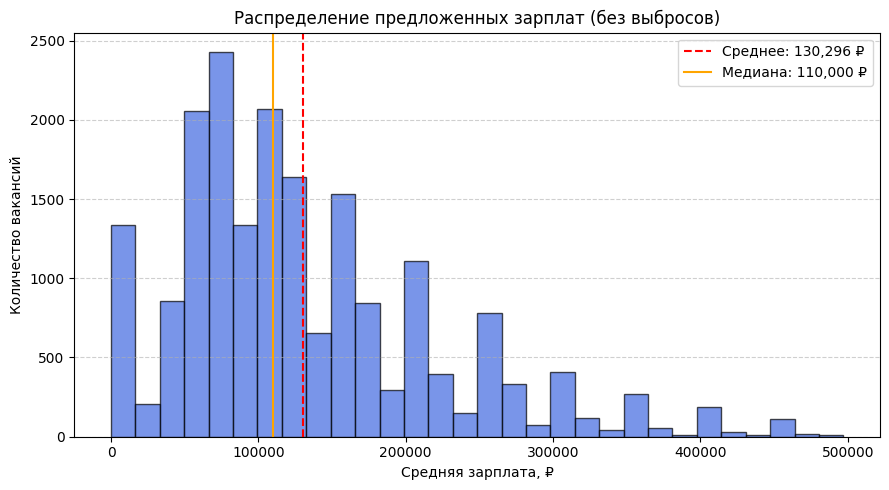

In [151]:
avg_salaries = avg_salaries[avg_salaries < 500_000]

plt.figure(figsize=(9, 5))
plt.hist(avg_salaries, bins=30, color='royalblue', edgecolor='black', alpha=0.7)

mean_val = avg_salaries.mean()
median_val = avg_salaries.median()

plt.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Среднее: {mean_val:,.0f} ₽')
plt.axvline(median_val, color='orange', linestyle='-', linewidth=1.5, label=f'Медиана: {median_val:,.0f} ₽')

plt.title('Распределение предложенных зарплат (без выбросов)')
plt.xlabel('Средняя зарплата, ₽')
plt.ylabel('Количество вакансий')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Как мы знаем в IT довольно высокие средние зарплаты, следовательно если работать в IT будешь в достатке

#2.Высокие зарплаты это хорошо, а как же опыт?

Давайте рассмотрим специалистов с каким опытом сейчас ищут:

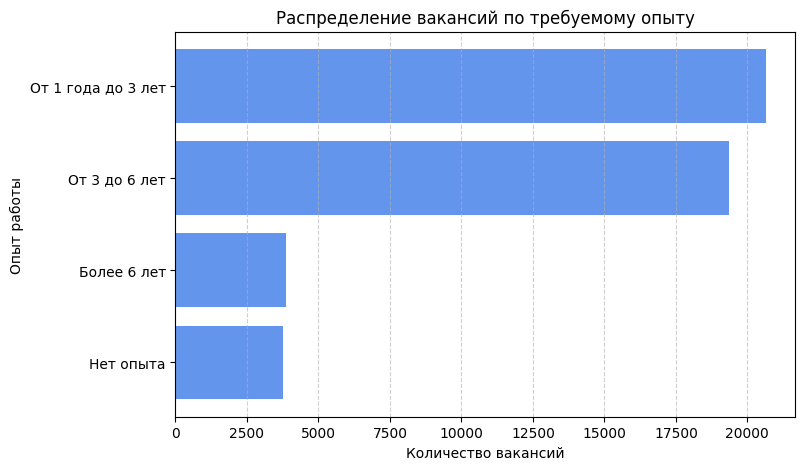

In [152]:
experience_counts = data['experience_name'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
plt.barh(experience_counts.index, experience_counts.values, color='cornflowerblue')
plt.title('Распределение вакансий по требуемому опыту')
plt.xlabel('Количество вакансий')
plt.ylabel('Опыт работы')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

Как видим рынок имеет довольно хорошее распределение, нужны как и специалисты с опытом, так и без

#3.А где в мире можно работать в IT?

Давайте рассмотрим где же расположены наши вакансии в мире?

In [153]:
coords = data.dropna(subset=["address_lat", "address_lng"]).copy()
coords["address_lat"] = coords["address_lat"].astype(float)
coords["address_lng"] = coords["address_lng"].astype(float)

max_points = 20000
if len(coords) > max_points:
    coords = coords.sample(max_points, random_state=42)

hover_text = (
    "Город где ищут работника: " + coords["city"].astype(str) +
    "<br>Компания: " + coords["employer"].astype(str) +
    "<br>Вакансия: " + coords["title"].astype(str)
)

fig = go.Figure()

fig.add_trace(go.Scattergeo(
    lon=coords["address_lng"],
    lat=coords["address_lat"],
    mode="markers",
    text=hover_text,
    hoverinfo="text",
    marker=dict(
        size=3,
        opacity=0.7
    )
))

fig.update_layout(
    title="Координаты главных офисов на карте мира",
    geo=dict(
        projection_type="natural earth",
        showland=True,
        landcolor="rgb(240, 240, 240)",
        showcountries=True,
        countrycolor="rgb(200, 200, 200)",
    ),
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()

В данном датасете видим что даже некоторые зарубежные компании набирают работников из России, следовательно на международном рынке труда российские работники очень ценяться

#4.А я студент...

Так как студентам еще нужно учиться в вузе то....

Давайте рассмотрим формат работы в IT

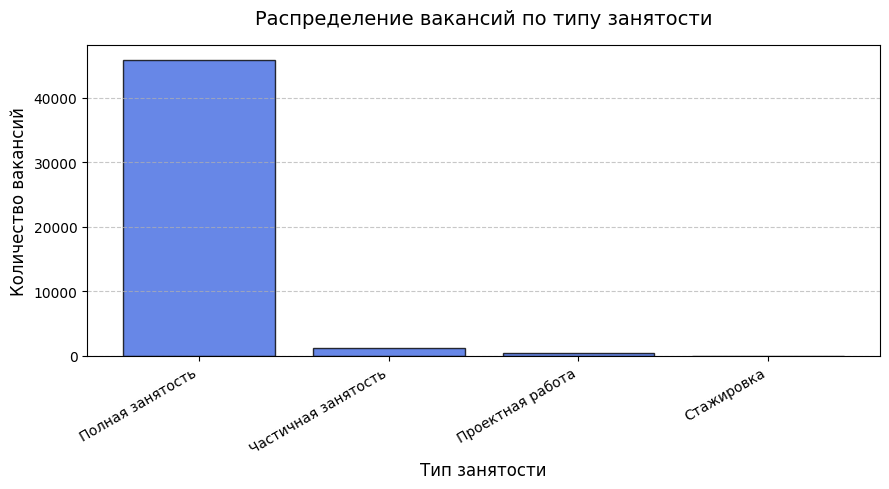

In [154]:
employment_counts = data['employment'].value_counts(dropna=True)
plt.figure(figsize=(9, 5))
plt.bar(employment_counts.index, employment_counts.values, color='royalblue', edgecolor='black', alpha=0.8)
plt.title('Распределение вакансий по типу занятости', fontsize=14, pad=15)
plt.xlabel('Тип занятости', fontsize=12)
plt.ylabel('Количество вакансий', fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Видим что хоть работа в IT и хорошо оплачивается, но чаще всего оно занимает мног времени что является минусом студенту

#2 Часть

# Бизнес задача 1(Распределение среди городов)

Определить, в каких городах размещено больше всего вакансий и где наблюдается наибольший спрос на сотрудников

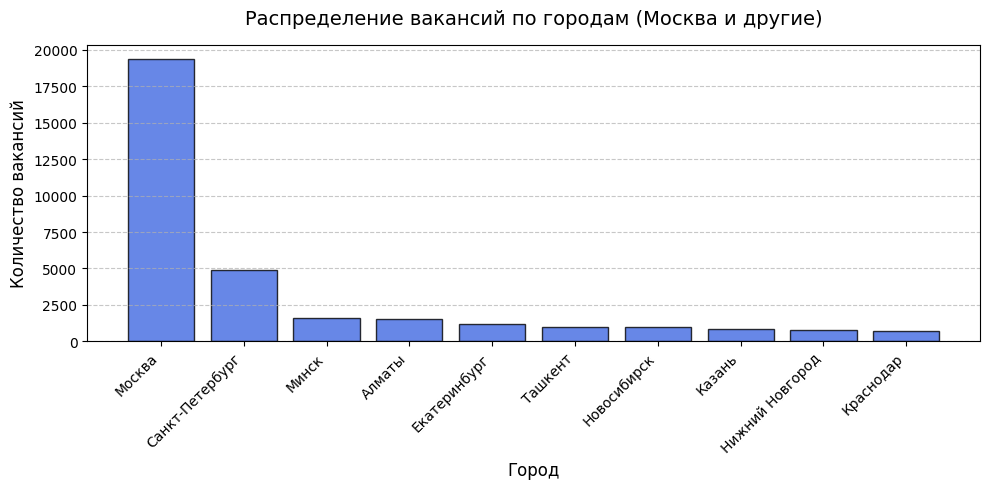

In [155]:
city_col = None
for c in ['city_clean', 'city', 'geo']:
    if c in data.columns:
        city_col = c
        break


city_counts = data[city_col].value_counts(dropna=True)

top_n = 10
top_cities = city_counts.head(top_n)

if 'Москва' not in top_cities.index and 'Москва' in city_counts.index:
    top_cities = pd.concat([pd.Series({'Москва': city_counts['Москва']}), top_cities])

plt.figure(figsize=(10, 5))
plt.bar(top_cities.index, top_cities.values, color='royalblue', edgecolor='black', alpha=0.8)

plt.title('Распределение вакансий по городам (Москва и другие)', fontsize=14, pad=15)
plt.xlabel('Город', fontsize=12)
plt.ylabel('Количество вакансий', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Вывод:

Можем заметить как один город является центром вакансий в то время как другие тоже имеют вес, но не сильно

Можем заметить что датасет довольно продвинут и есть для сравнения не только Россия но и другие страны

#Бизнес задача 2(Самые высокие зарплаты)

Понять, какие профессии или направления предлагают самые высокие зарплаты.

In [156]:
data_rur = data[data["currency"] == "RUR"].copy()

# Считаем "единую" зарплату по вакансии
def calc_salary(row):
    if pd.notna(row["salary_from"]) and pd.notna(row["salary_to"]):
        return (row["salary_from"] + row["salary_to"]) / 2
    elif pd.notna(row["salary_from"]):
        return row["salary_from"]
    elif pd.notna(row["salary_to"]):
        return row["salary_to"]
    else:
        return None

data_rur["salary_value"] = data_rur.apply(calc_salary, axis=1)

data_rur = data_rur.dropna(subset=["salary_value"])

data_rur = data_rur[
    (data_rur["salary_value"] >= 10_000) &
    (data_rur["salary_value"] <= 1_000_000)
]
title_salary = (
    data_rur
    .groupby("title")
    .agg(
        avg_salary=("salary_value", "mean"),
        count=("salary_value", "size")
    )
    .reset_index()
)

title_salary_filtered = title_salary[title_salary["count"] >= 30]

top10_titles = (
    title_salary_filtered
    .sort_values("avg_salary", ascending=False)
    .head(10)
)

In [157]:
print("Общая статистика по зарплатам (RUR):")
print(data_rur["salary_value"].describe())

Общая статистика по зарплатам (RUR):
count      17562.000000
mean      137228.602409
std        86862.864552
min        10000.000000
25%        75000.000000
50%       115000.000000
75%       175000.000000
max      1000000.000000
Name: salary_value, dtype: float64


Вывод:

Можем заметить что распределене зарплат довольно равномерное

Как же зарплаты распределены?

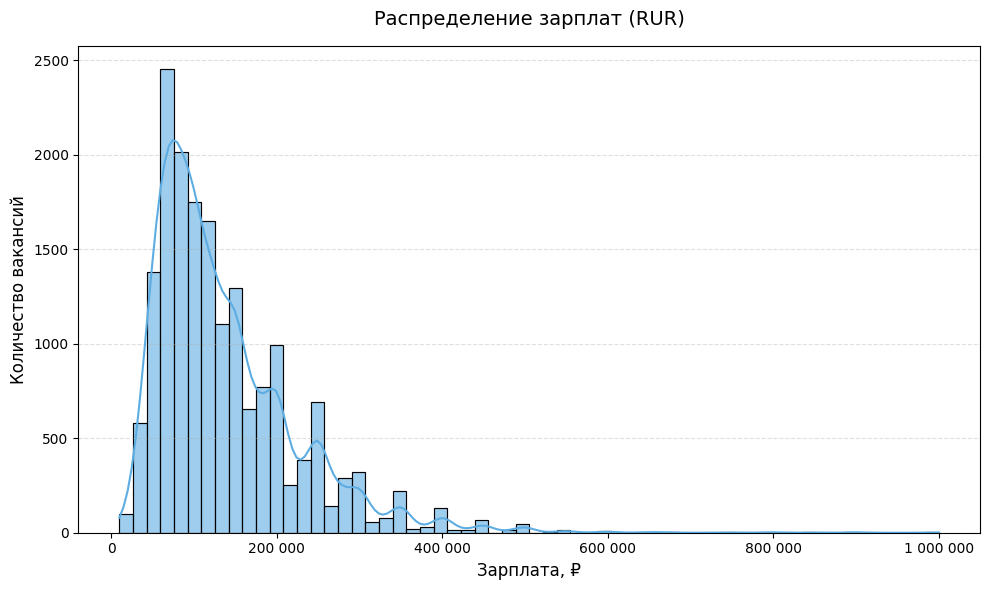

In [158]:
plt.figure(figsize=(10, 6))
sns.histplot(data_rur["salary_value"], kde=True, bins=60, color="#5DADE2", alpha=0.6)

plt.title("Распределение зарплат (RUR)", fontsize=14, pad=15)
plt.xlabel("Зарплата, ₽", fontsize=12)
plt.ylabel("Количество вакансий", fontsize=12)

plt.gca().xaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", " "))
)

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

Топ 10 должностей по зарплате

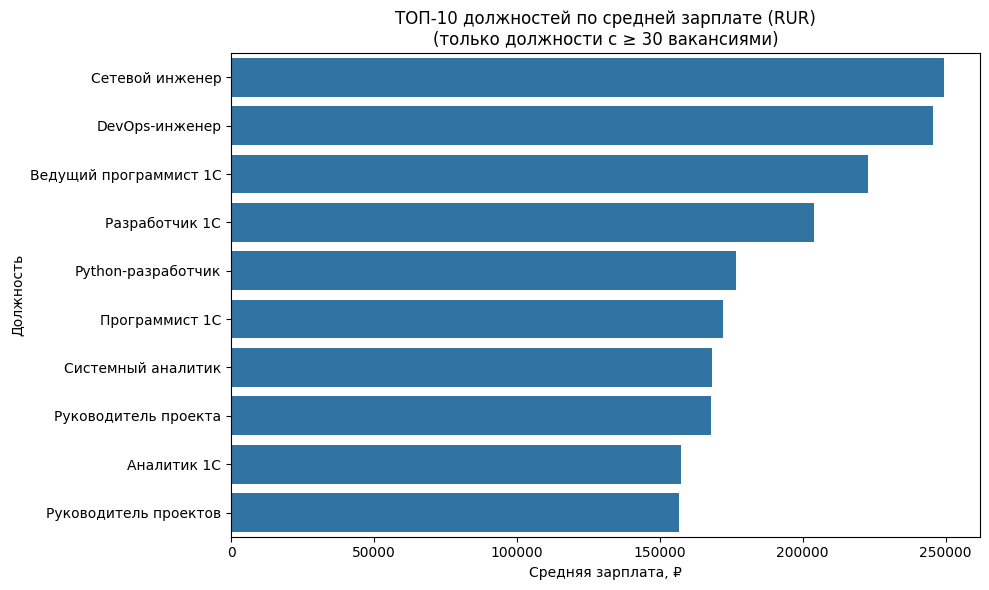

In [159]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10_titles,
    x="avg_salary",
    y="title"
)
plt.title("ТОП-10 должностей по средней зарплате (RUR)\n(только должности с ≥ 30 вакансиями)")
plt.xlabel("Средняя зарплата, ₽")
plt.ylabel("Должность")
plt.tight_layout()
plt.show()

Топ 10 городов по средней зарплате


ТОП-10 городов по средней зарплате:
                 city     avg_salary  count
303            Москва  181484.874264   5603
424   Санкт-Петербург  148817.839331   1973
164        Зеленоград  137518.103448     58
311  Набережные Челны  137291.573034     89
181            Казань  129997.468619    478
341       Новосибирск  129666.707059    425
144      Екатеринбург  127459.441080    611
90        Владивосток  125842.535135    185
236         Краснодар  124755.805252    457
423            Самара  117639.243137    255


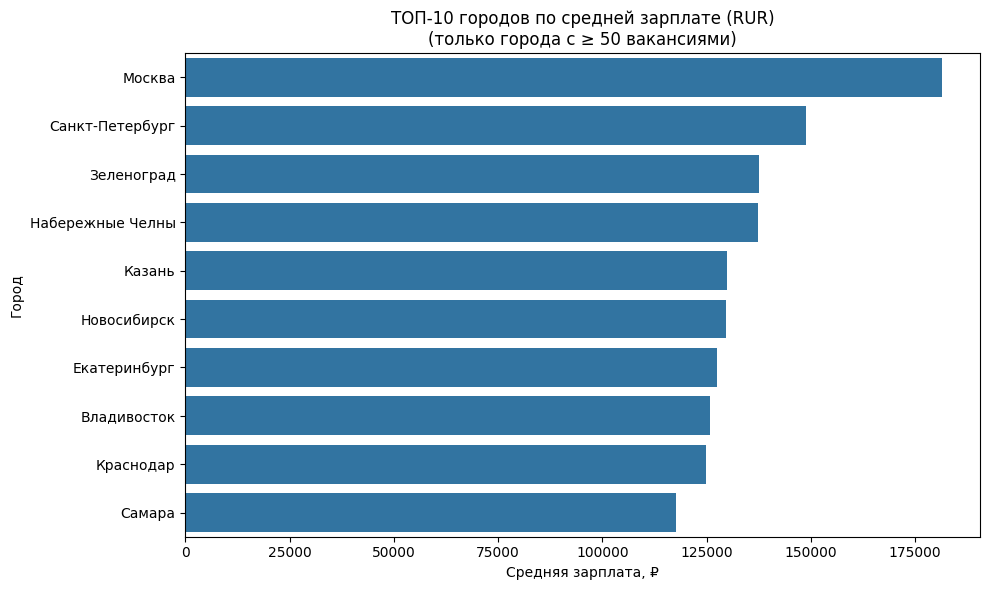

In [160]:
city_salary = (
    data_rur
    .groupby("city")
    .agg(
        avg_salary=("salary_value", "mean"),
        count=("salary_value", "size")
    )
    .reset_index()
)

city_salary_filtered = city_salary[city_salary["count"] >= 50]

top10_cities = (
    city_salary_filtered
    .sort_values("avg_salary", ascending=False)
    .head(10)
)

print("\nТОП-10 городов по средней зарплате:")
print(top10_cities)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10_cities,
    x="avg_salary",
    y="city"
)
plt.title("ТОП-10 городов по средней зарплате (RUR)\n(только города с ≥ 50 вакансиями)")
plt.xlabel("Средняя зарплата, ₽")
plt.ylabel("Город")
plt.tight_layout()
plt.show()

# Бизнес задача 3(Вакансии для  студентов)

Определить, процентное отношения стажировок и вакансии без опыта:

Всего вакансий: 17562
Вакансий для студентов/без опыта: 2431 (13.84%)


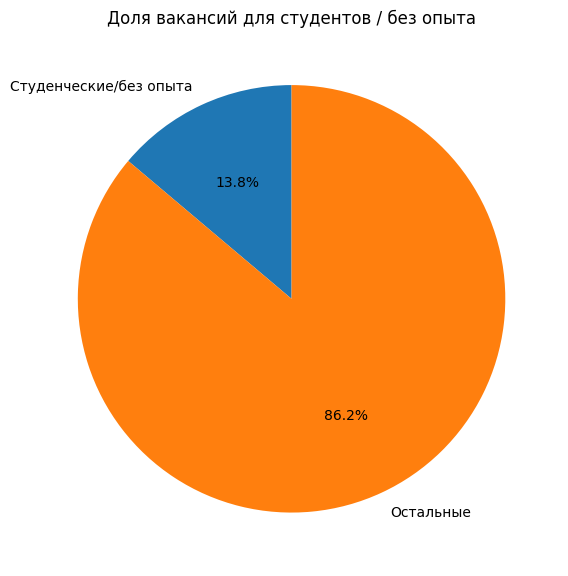

In [161]:
data_rur["salary_value_clean"] = data_rur["salary_value"].where(
    (data_rur["salary_value"] >= 5_000) & (data_rur["salary_value"] <= 1_000_000)
)

mask_internship = data_rur["internship"] == True

mask_no_exp = data_rur["experience_name"].str.contains("нет опыта", case=False, na=False)

mask_student = mask_internship | mask_no_exp

df_student = data_rur[mask_student].copy()
df_non_student = data_rur[~mask_student].copy()

print(f"Всего вакансий: {len(data_rur)}")
print(f"Вакансий для студентов/без опыта: {len(df_student)} "
      f"({len(df_student) / len(data_rur) * 100:.2f}%)")

share_data = pd.DataFrame({
    "segment": ["Студенческие/без опыта", "Остальные"],
    "count": [len(df_student), len(df_non_student)]
})

plt.figure(figsize=(6, 6))
plt.pie(
    share_data["count"],
    labels=share_data["segment"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Доля вакансий для студентов / без опыта")
plt.tight_layout()
plt.show()

Теперь рассмотрим на какие должности студентов чаще всего берут


ТОП-10 должностей для студентов / без опыта ):
                                        title  count
0                     Системный администратор    102
2              Аналитик упоминаний в соцсетях     36
3                    Администратор баз данных     34
4                              Дизайнер сайта     32
5                        Графический дизайнер     31
6                         Инженер-программист     28
7                                 Программист     18
8   Специалист по информационной безопасности     16
9                     DevOps инженер (ученик)     16
10         Помощник системного администратора     15


/tmp/ipython-input-3321196778.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




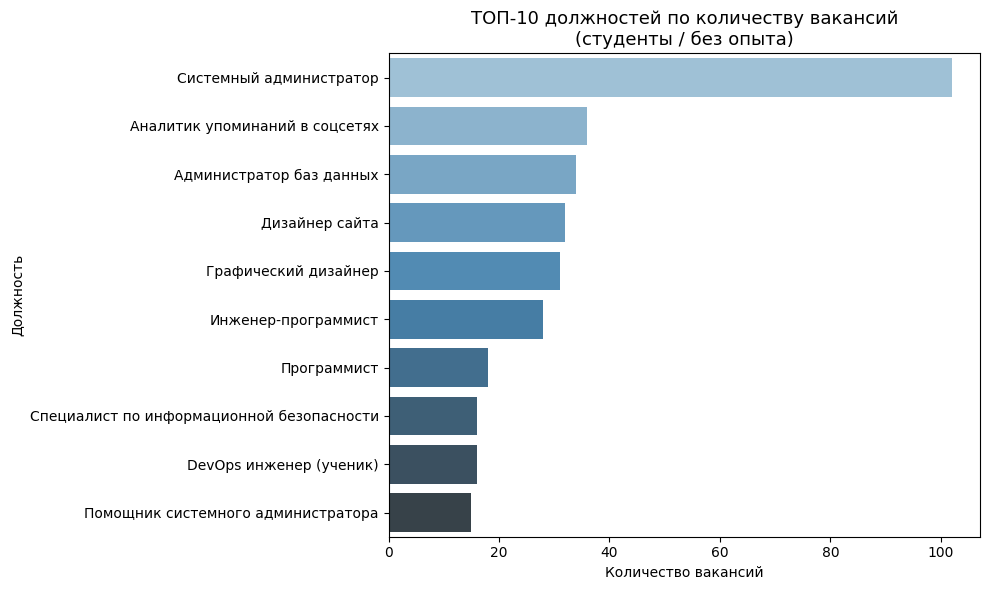

In [162]:
top_titles_student = (
    df_student["title"]
    .value_counts()
    .head(20)
    .reset_index()
)
top_titles_student.columns = ["title", "count"]

top_titles_student = top_titles_student[
    ~top_titles_student["title"].str.lower().str.contains("флорист")
]

top_titles_student = top_titles_student.head(10)

print("\nТОП-10 должностей для студентов / без опыта ):")
print(top_titles_student)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_titles_student,
    x="count",
    y="title",
    palette="Blues_d"
)
plt.title("ТОП-10 должностей по количеству вакансий\n(студенты / без опыта)", fontsize=13)
plt.xlabel("Количество вакансий")
plt.ylabel("Должность")
plt.tight_layout()
plt.show()


Видим что чаще всего ищут Системных администраторов , флористов и графических дизайнеров

Теперь рассмотрим лучшие города по количеству вакансий для студентов


ТОП-10 городов по количеству вакансий для студентов / без опыта:
              city  count
0           Москва    493
1  Санкт-Петербург    169
2     Екатеринбург     78
3           Казань     78
4   Ростов-на-Дону     64
5  Нижний Новгород     63
6      Новосибирск     57
7          Воронеж     53
8           Самара     53
9        Краснодар     52


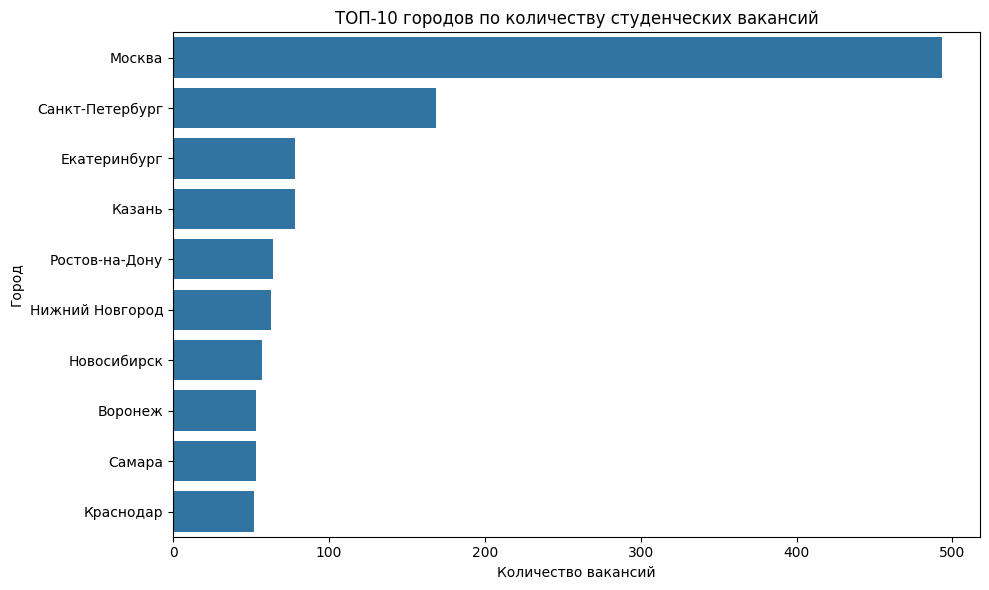

In [163]:
top_cities_student = (
    df_student["city"]
    .value_counts()
    .head(10)
    .reset_index()
)
top_cities_student.columns = ["city", "count"]

print("\nТОП-10 городов по количеству вакансий для студентов / без опыта:")
print(top_cities_student)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_cities_student,
    x="count",
    y="city"
)
plt.title("ТОП-10 городов по количеству студенческих вакансий")
plt.xlabel("Количество вакансий")
plt.ylabel("Город")
plt.tight_layout()
plt.show()




Статистика по зарплатам (RUR) для сегментов:
                        count           mean           std  min      25%  \
segment                                                                    
Остальные             15240.0  146093.000394  88659.411208  1.5  80500.0   
Студенты / без опыта   2461.0   75680.648111  51955.349591  2.0  50000.0   

                           50%       75%        max  
segment                                              
Остальные             123950.0  190000.0  1165000.0  
Студенты / без опыта   65000.0   87500.0  1000000.0  


/tmp/ipython-input-3301934428.py:38: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




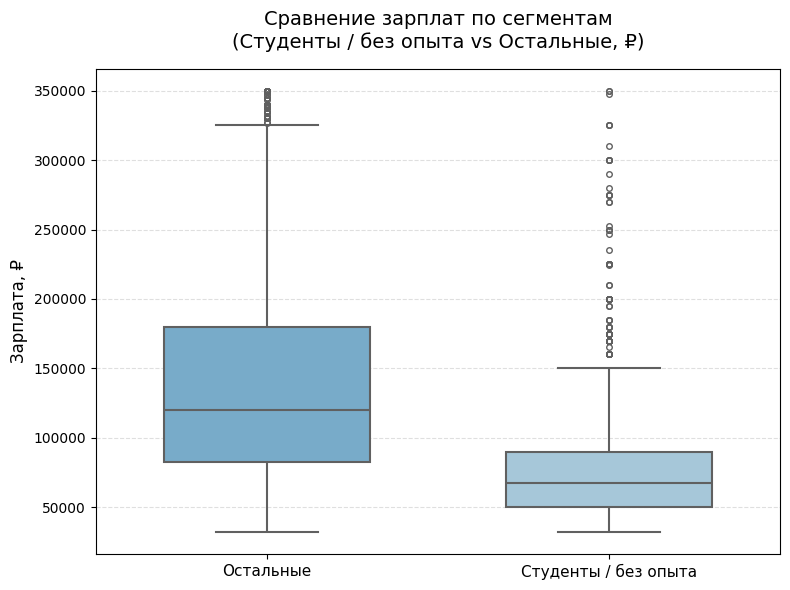

In [164]:
df_rur = data[data["currency"] == "RUR"].copy()

if "salary_value" not in df_rur.columns:
    def calc_salary(row):
        if pd.notna(row["salary_from"]) and pd.notna(row["salary_to"]):
            return (row["salary_from"] + row["salary_to"]) / 2
        elif pd.notna(row["salary_from"]):
            return row["salary_from"]
        elif pd.notna(row["salary_to"]):
            return row["salary_to"]
        else:
            return None

    df_rur["salary_value"] = df_rur.apply(calc_salary, axis=1)

# Убираем пропуски
df_rur = df_rur.dropna(subset=["salary_value"])

mask_student_rur = (
    (df_rur["internship"] == True) |
    (df_rur["experience_name"].str.contains("нет опыта", case=False, na=False))
)

df_rur["segment"] = "Остальные"
df_rur.loc[mask_student_rur, "segment"] = "Студенты / без опыта"

print("\nСтатистика по зарплатам (RUR) для сегментов:")
print(df_rur.groupby("segment")["salary_value"].describe())

q_low = df_rur["salary_value"].quantile(0.02)
q_high = df_rur["salary_value"].quantile(0.97)
df_rur_trimmed = df_rur[
    (df_rur["salary_value"] >= q_low) &
    (df_rur["salary_value"] <= q_high)
].copy()

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df_rur_trimmed,
    x="segment",
    y="salary_value",
    showfliers=True,
    fliersize=4,
    linewidth=1.5,
    palette=["#6BAED6", "#9ECAE1"],
    width=0.6
)

plt.title("Сравнение зарплат по сегментам\n(Студенты / без опыта vs Остальные, ₽)", fontsize=14, pad=15)
plt.xlabel("")
plt.ylabel("Зарплата, ₽", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


#Бизнес задачи 4(Распределния по форме работы)

Изучить популярность форматов работы (удалённая, гибридная, офисная) и графиков (полный день, сменный, гибкий график).

Определить распределение вакансий по форматам работы

/tmp/ipython-input-3397003124.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




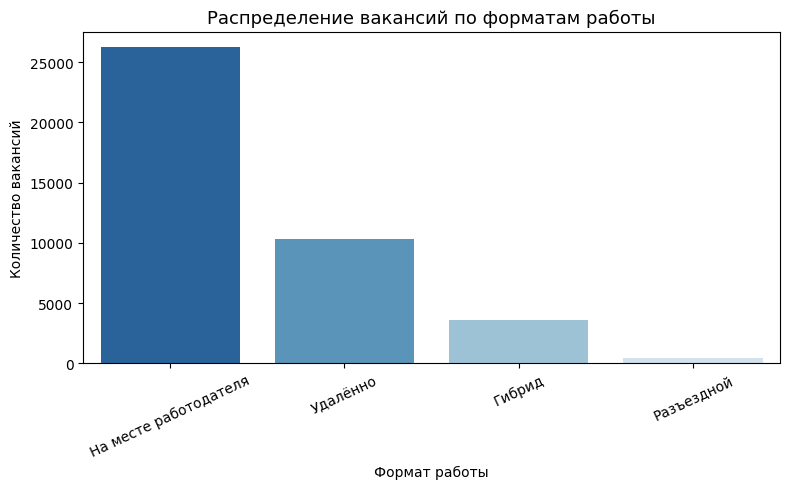

work_format_name
На месте работодателя    64.61
Удалённо                 25.42
Гибрид                    8.86
Разъездной                1.11
Name: proportion, dtype: float64

In [165]:
plt.figure(figsize=(8,5))
sns.countplot(data=data, x='work_format_name',
              order=data['work_format_name'].value_counts().index,
              palette='Blues_r')
plt.title('Распределение вакансий по форматам работы', fontsize=13)
plt.xlabel('Формат работы')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

data['work_format_name'].value_counts(normalize=True).mul(100).round(2)

Определим распределение вакансий по типам графиков


/tmp/ipython-input-2278775445.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




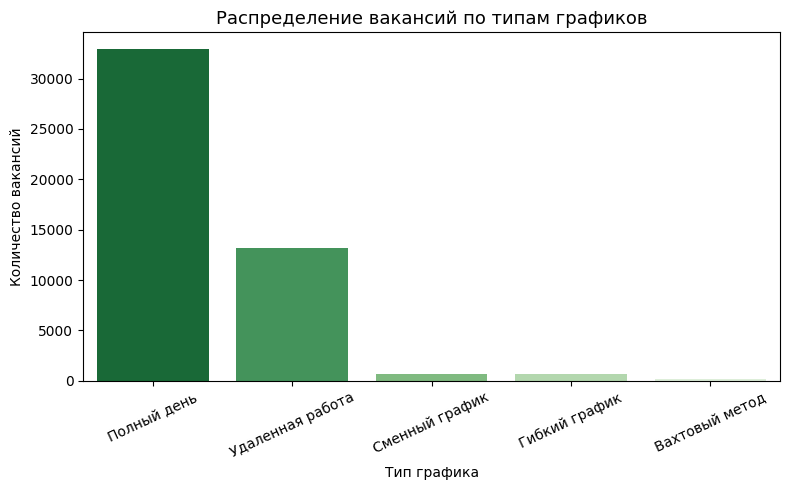

schedule_name
Полный день         69.14
Удаленная работа    27.63
Сменный график       1.40
Гибкий график        1.36
Вахтовый метод       0.46
Name: proportion, dtype: float64

In [166]:
plt.figure(figsize=(8,5))
sns.countplot(data=data, x='schedule_name',
              order=data['schedule_name'].value_counts().index,
              palette='Greens_r')
plt.title('Распределение вакансий по типам графиков', fontsize=13)
plt.xlabel('Тип графика')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

data['schedule_name'].value_counts(normalize=True).mul(100).round(2)


Сравним популярность форматов и графиков в разных регионах


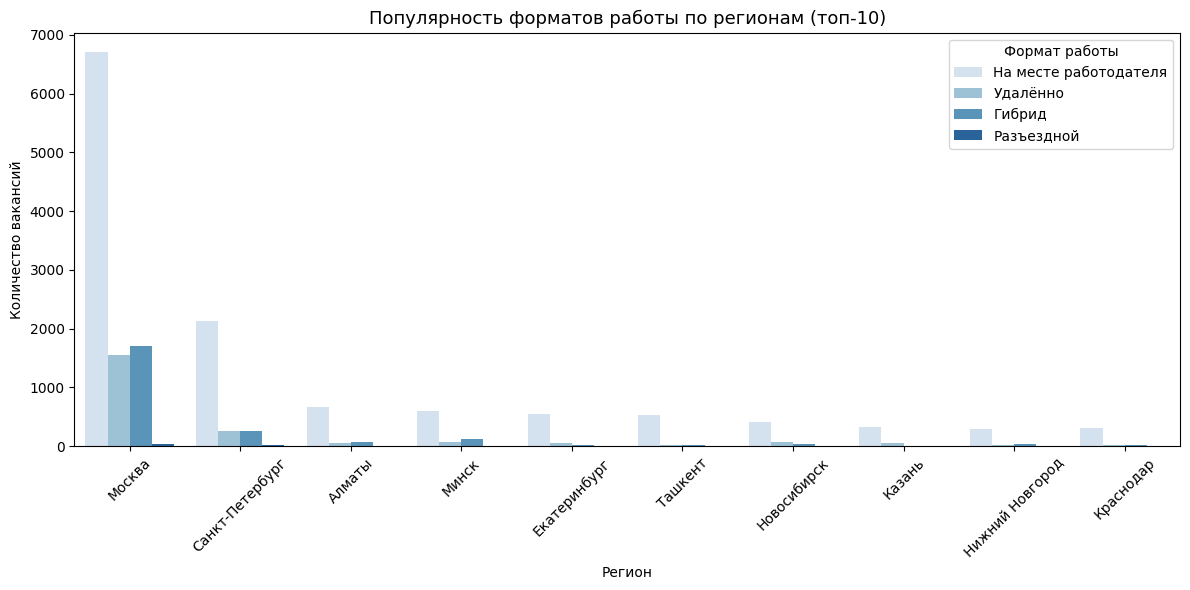

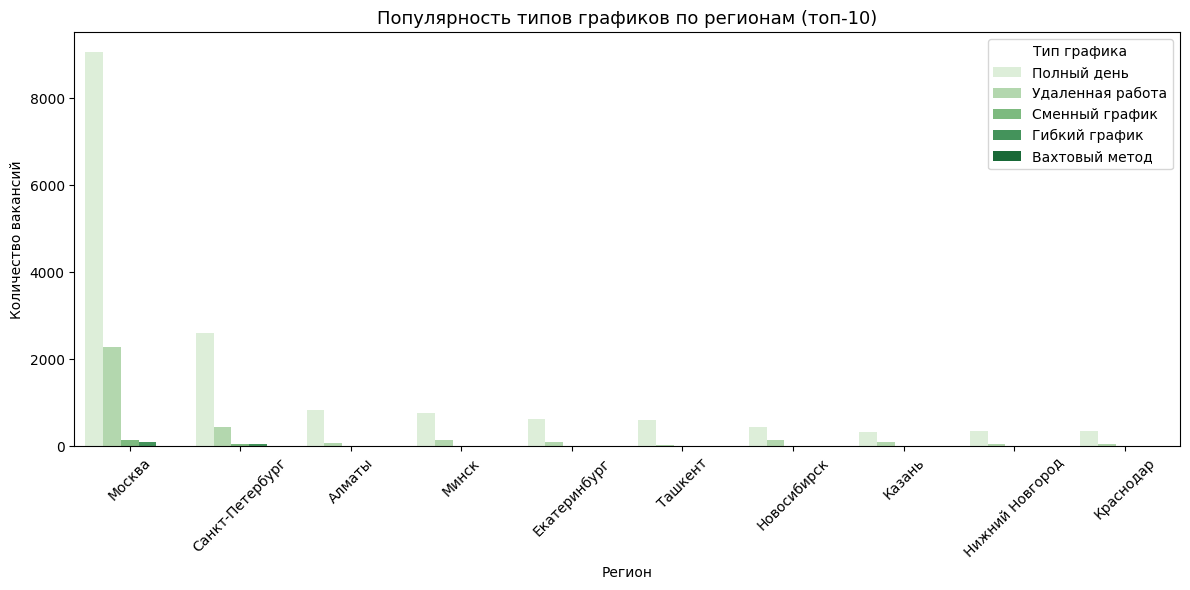

In [167]:
plt.figure(figsize=(12,6))
sns.countplot(data=data, x='address_city', hue='work_format_name',
              order=data['address_city'].value_counts().index[:10],
              palette='Blues')
plt.title('Популярность форматов работы по регионам (топ-10)', fontsize=13)
plt.xlabel('Регион')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=45)
plt.legend(title='Формат работы')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.countplot(data=data, x='address_city', hue='schedule_name',
              order=data['address_city'].value_counts().index[:10],
              palette='Greens')
plt.title('Популярность типов графиков по регионам (топ-10)', fontsize=13)
plt.xlabel('Регион')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=45)
plt.legend(title='Тип графика')
plt.tight_layout()
plt.show()


Выявим тренды по профессиональным категориям


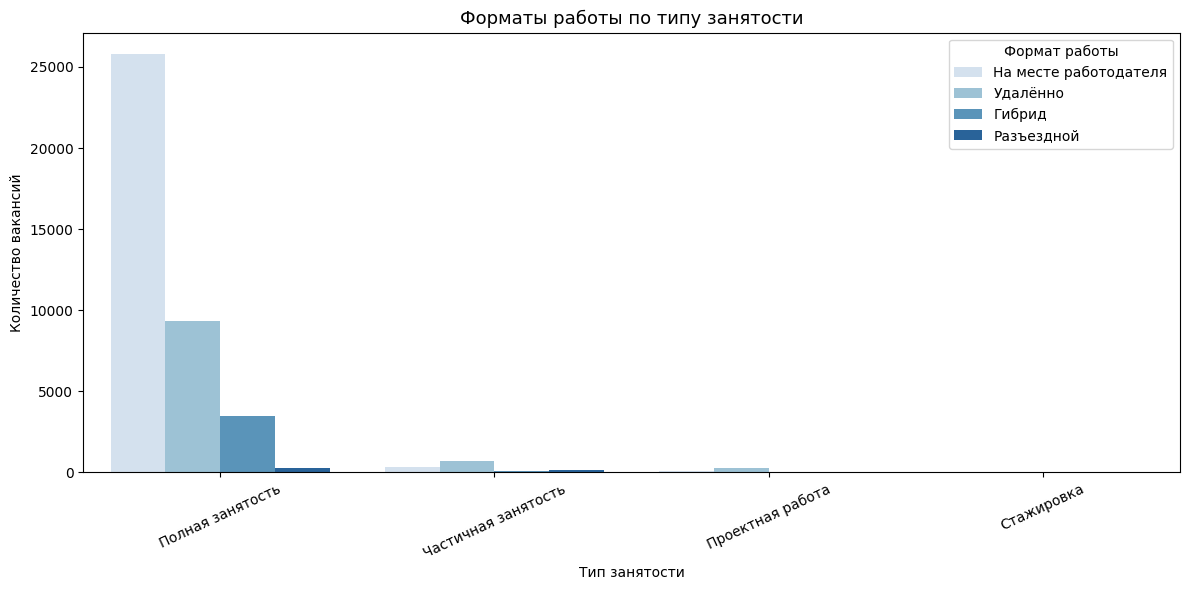

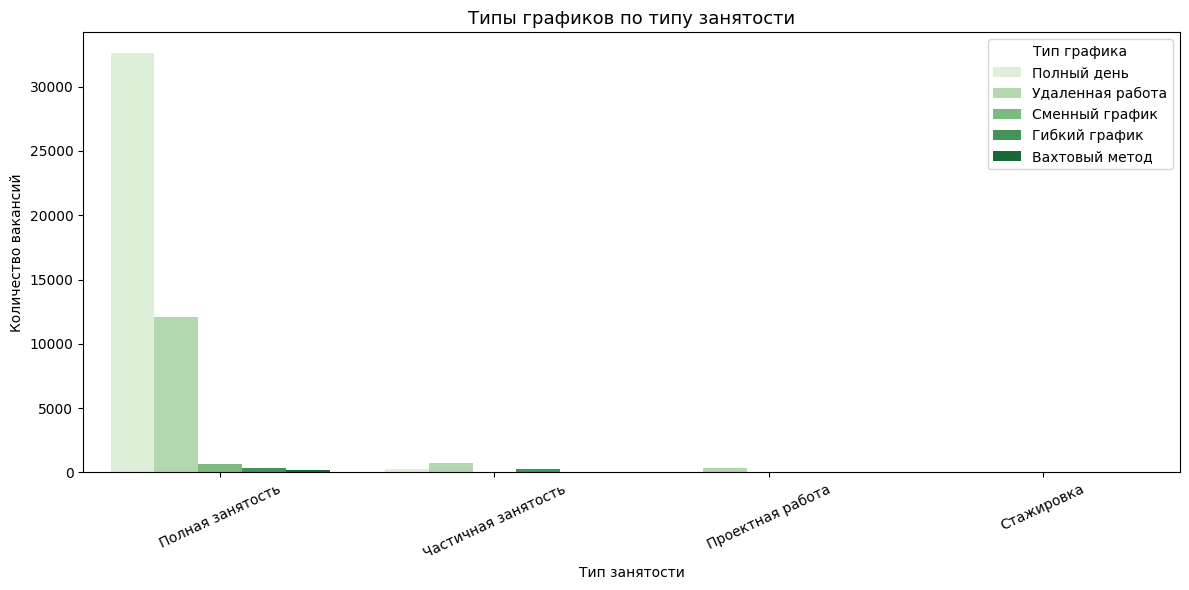

In [168]:
plt.figure(figsize=(12,6))
sns.countplot(data=data, x='employment', hue='work_format_name',
              order=data['employment'].value_counts().index,
              palette='Blues')
plt.title('Форматы работы по типу занятости', fontsize=13)
plt.xlabel('Тип занятости')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=25)
plt.legend(title='Формат работы')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.countplot(data=data, x='employment', hue='schedule_name',
              order=data['employment'].value_counts().index,
              palette='Greens')
plt.title('Типы графиков по типу занятости', fontsize=13)
plt.xlabel('Тип занятости')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=25)
plt.legend(title='Тип графика')
plt.tight_layout()
plt.show()

# Бизнес задача 5(Опыт в работе)

Определить, какой опыт чаще всего требуют работодатели и как он влияет на уровень зарплаты.

Определим, какой опыт встречается чаще всего

/tmp/ipython-input-334943427.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




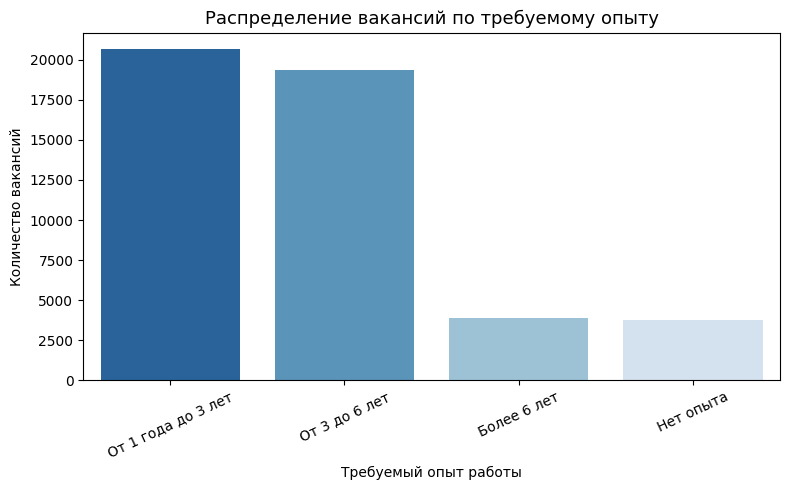

experience_name
От 1 года до 3 лет    43.34
От 3 до 6 лет         40.63
Более 6 лет            8.13
Нет опыта              7.89
Name: proportion, dtype: float64

In [169]:
plt.figure(figsize=(8,5))
sns.countplot(data=data, x='experience_name',
              order=data['experience_name'].value_counts().index,
              palette='Blues_r')
plt.title('Распределение вакансий по требуемому опыту', fontsize=13)
plt.xlabel('Требуемый опыт работы')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

data['experience_name'].value_counts(normalize=True).mul(100).round(2)


Больше

Рассчитаем среднюю зарплату по категориям опыта

/tmp/ipython-input-3846401495.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




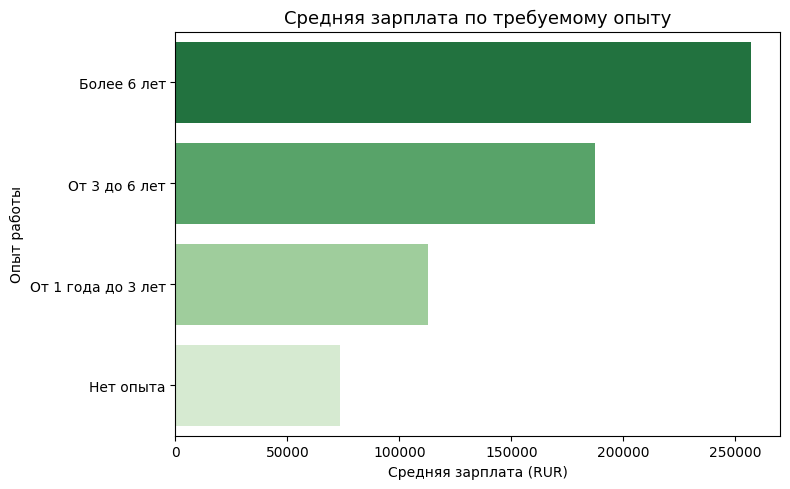

experience_name   salary_value
0         Более 6 лет  257197.166851
3       От 3 до 6 лет  187479.557366
2  От 1 года до 3 лет  112905.990179
1           Нет опыта   73340.680222

In [170]:
exp_salary = (
    data_rur
    .groupby('experience_name')['salary_value']
    .mean()
    .reset_index()
    .sort_values('salary_value', ascending=False)
)

plt.figure(figsize=(8,5))
sns.barplot(data=exp_salary, x='salary_value', y='experience_name', palette='Greens_r')
plt.title('Средняя зарплата по требуемому опыту', fontsize=13)
plt.xlabel('Средняя зарплата (RUR)')
plt.ylabel('Опыт работы')
plt.tight_layout()
plt.show()

exp_salary


#Бизнес задача 6(Навыки)

Выявить, какие навыки чаще всего встречаются в описаниях вакансий.

In [171]:
data_skills = data.dropna(subset=['skills']).copy()

# Разбиваем и очищаем навыки
all_skills = (
    data_skills['skills']
    .str.split(',')          # разбиваем по запятой
    .explode()               # превращаем списки в строки
    .str.strip()             # убираем пробелы
    .str.replace('[', '', regex=False)
    .str.replace(']', '', regex=False)
    .str.replace("'", '', regex=False)
    .str.replace('"', '', regex=False)
    .replace('', pd.NA)      # убираем пустые значения
    .dropna()
    .value_counts()          # считаем частоту
    .reset_index()
)

all_skills.columns = ['skill', 'count']

all_skills.head(15)


skill  count
0          Linux    663
1     Kubernetes    610
2         Python    593
3     PostgreSQL    536
4          React    510
5   Apache Kafka    423
6           BPMN    422
7           Java    406
8         Docker    367
9         DevOps    358
10           SQL    340
11        Oracle    308
12           LLM    303
13       Quarkus    300
14   Spring Boot    300

Видим что самый поулярные навыки это Linux, Kubernetes и еще неколько(значния которых выше 300)



Визуализируем самые популярные навыки

/tmp/ipython-input-1268426186.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




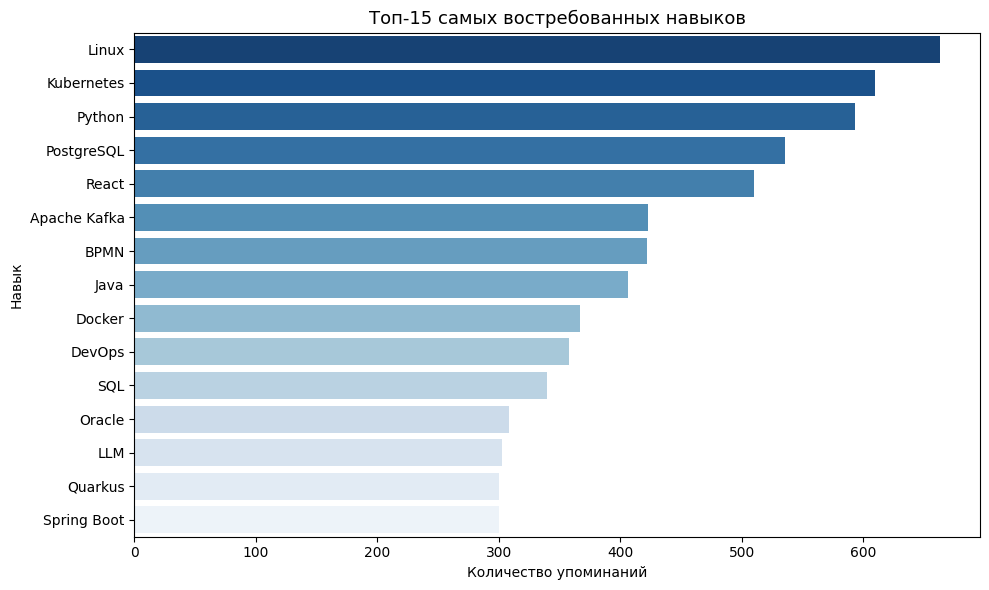

In [172]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=all_skills.head(15),
    x='count', y='skill', palette='Blues_r'
)
plt.title('Топ-15 самых востребованных навыков', fontsize=13)
plt.xlabel('Количество упоминаний')
plt.ylabel('Навык')
plt.tight_layout()
plt.show()


Здесь можем рассмотреть прошлый вывод более наглядно

Рассчитаем среднюю зарплату по каждому навыку

In [173]:
data_with_salary = data_rur.dropna(subset=['skills', 'salary_value']).copy()

data_with_salary = data_with_salary.assign(skills=data_with_salary['skills'].str.split(',')).explode('skills')
data_with_salary['skills'] = data_with_salary['skills'].str.strip()

skill_salary = (
    data_with_salary
    .groupby('skills', as_index=False)
    .agg(
        avg_salary=('salary_value', 'mean'),
        count=('salary_value', 'size')
    )
)

skill_salary = skill_salary[skill_salary['count'] >= 20]

skill_salary['skills'] = (
    skill_salary['skills']
    .str.strip()
    .str.replace('[', '', regex=False)
    .str.replace(']', '', regex=False)
    .str.replace("'", '', regex=False)
    .str.replace('"', '', regex=False)
    .str.replace('`', '', regex=False)
)

skill_salary = skill_salary.sort_values('avg_salary', ascending=False)

skill_salary.head(15)


skills     avg_salary  count
6       Apache Airflow  316780.000000     25
40                 LLM  311645.833333     24
93     Английский язык  311645.833333     24
99   Машинное обучение  311645.833333     24
69                 SQL  304134.146341     41
150                PHP  303500.000000     20
153             Python  298057.692308     26
31                 Git  277727.272727     22
48               MySQL  269130.434783     23
156                SQL  241913.043478     23
22              Docker  134370.000000     30
56          PostgreSQL  134025.581395     43
13                BPMN  133372.641509    106
95    Бизнес аналитика  133372.641509    106
120   Системный анализ  133372.641509    106

Визуализация

/tmp/ipython-input-1247188933.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




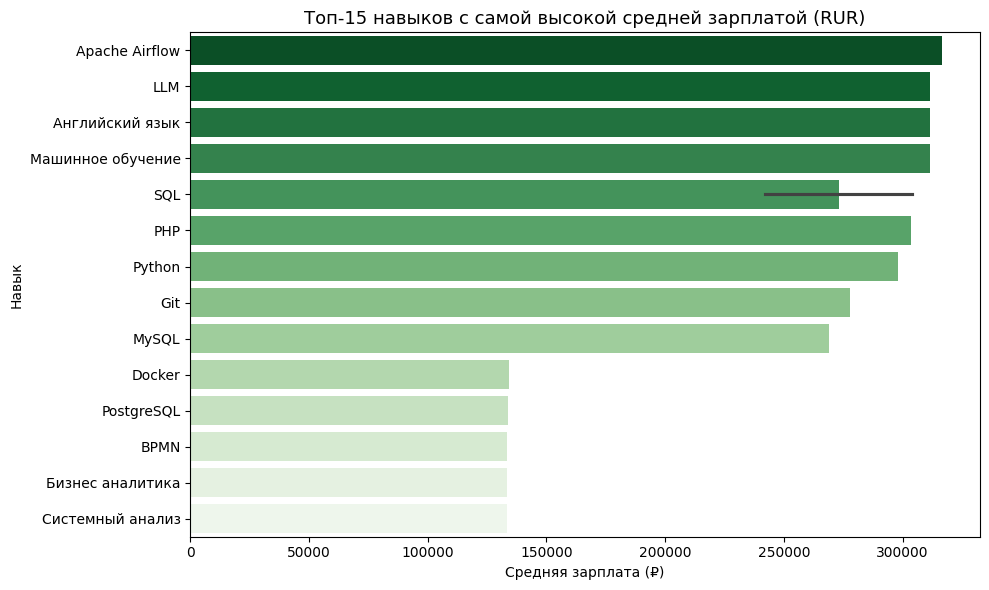

In [174]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=skill_salary.head(15),
    x='avg_salary', y='skills', palette='Greens_r'
)
plt.title('Топ-15 навыков с самой высокой средней зарплатой (RUR)', fontsize=13)
plt.xlabel('Средняя зарплата (₽)')
plt.ylabel('Навык')
plt.tight_layout()
plt.show()


Вывод: Можем сделать вывод что самые денежные навыки это apache airflow , LLM, Английский и другие

Так же на рынке довольно много денежных навыков

#Бизнес задача 7(Топ компаний работодателей)

Определить, какие компании размещают больше всего вакансий.

/tmp/ipython-input-878672936.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




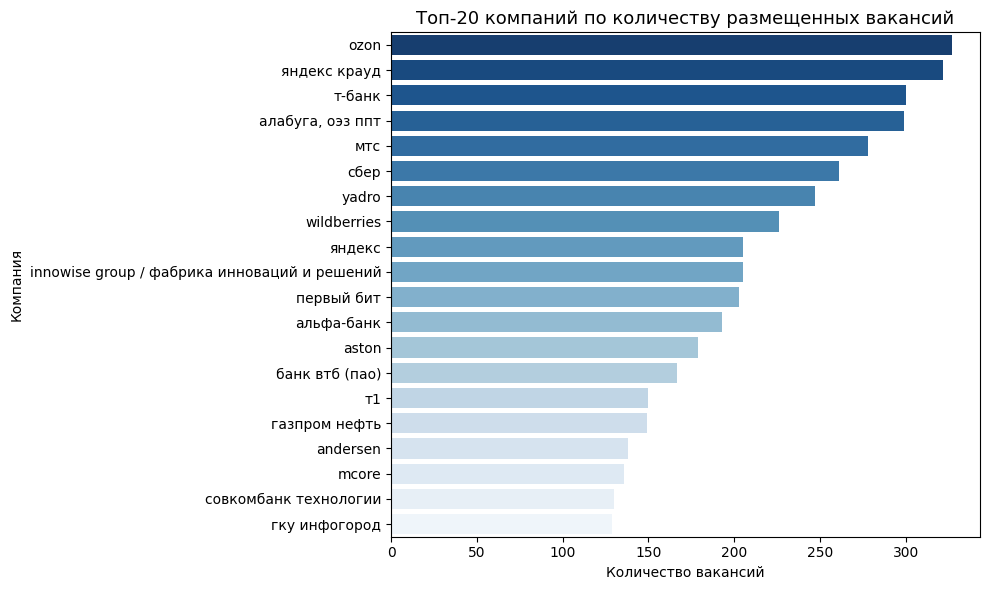

In [175]:
top_companies = (
    data['employer']
    .value_counts()
    .head(20)
    .reset_index()
)

top_companies.columns = ['employer', 'vacancy_count']

top_companies
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_companies,
    x='vacancy_count',
    y='employer',
    palette='Blues_r'
)
plt.title('Топ-20 компаний по количеству размещенных вакансий', fontsize=13)
plt.xlabel('Количество вакансий')
plt.ylabel('Компания')
plt.tight_layout()
plt.show()


Вывод

Топ компаний по размещению вакансий

1.Как и ожидалось топ вакансий заняли финтехи и крупные компании с большим обьемом работы

2.Первое место не особо отрывается от второго(разница в 10-12 вакансий)

#Бизнес задача 8(Уровень оплаты в отросли)

Сравнить уровень оплаты в разных отраслях (если отрасль зашита в employer или title).

Средняя зарплата по отраслям (₽):
           industry     avg_salary  count
0        HR / Кадры  197972.093750     32
1   IT / Разработка  162722.403980   5603
7           Продажи  159453.942073    328
2  Аналитика / Data  152003.853175   1890
6    Маркетинг / PR  147540.983607    488
4            Другое  122487.401865   7240
8           Финансы  116986.961538     52
5         Логистика  109746.650000     50
3            Дизайн   96845.321714   1879


/tmp/ipython-input-446756331.py:38: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




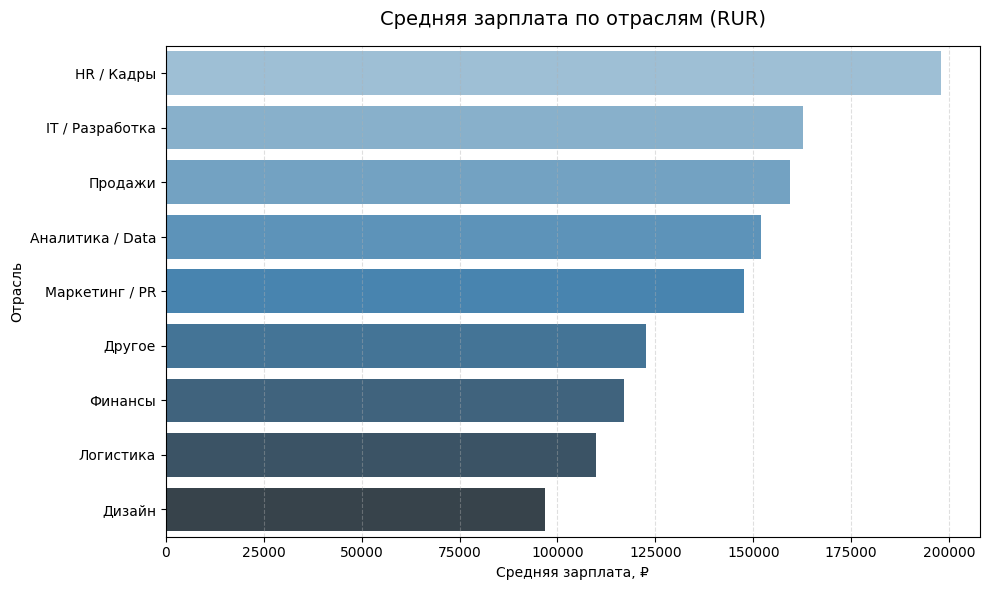

In [176]:
def detect_industry(title):
    title = str(title).lower()
    if any(word in title for word in ["аналитик", "data", "bi", "sql"]):
        return "Аналитика / Data"
    elif any(word in title for word in ["маркетинг", "smm", "бренд", "pr"]):
        return "Маркетинг / PR"
    elif any(word in title for word in ["продаж", "sales", "менеджер по продажам"]):
        return "Продажи"
    elif any(word in title for word in ["разработ", "developer", "программист", "инженер", "it"]):
        return "IT / Разработка"
    elif any(word in title for word in ["финанс", "бухгалтер", "экономист"]):
        return "Финансы"
    elif any(word in title for word in ["hr", "кадры", "рекрутер", "персонал"]):
        return "HR / Кадры"
    elif any(word in title for word in ["дизайн", "ui", "ux", "графический"]):
        return "Дизайн"
    elif any(word in title for word in ["логист", "доставка", "склад"]):
        return "Логистика"
    else:
        return "Другое"

data_rur["industry"] = data_rur["title"].apply(detect_industry)

industry_salary = (
    data_rur.groupby("industry")
    .agg(avg_salary=("salary_value", "mean"), count=("salary_value", "size"))
    .reset_index()
)

industry_salary = industry_salary[industry_salary["count"] >= 30]

industry_salary = industry_salary.sort_values("avg_salary", ascending=False)

print("Средняя зарплата по отраслям (₽):")
print(industry_salary)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=industry_salary,
    x="avg_salary",
    y="industry",
    palette="Blues_d"
)
plt.title("Средняя зарплата по отраслям (RUR)", fontsize=14, pad=15)
plt.xlabel("Средняя зарплата, ₽")
plt.ylabel("Отрасль")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


Вывод:

1. hr специалисты зарабатывают больше всех

2. Самым слабым по заработку это дизайн так как на направление можно легко зайти и кадров в нем достаточно

#Бизнес задача 9(Распределение по грейдам)

Определить распределение вакансий по грейдам и зарплатным вилкам

In [177]:
def detect_level(title):
    title = str(title).lower()
    if "junior" in title or "младш" in title:
        return "Junior"
    elif "middle" in title or "mid" in title or "специалист" in title:
        return "Middle"
    elif "senior" in title or "старш" in title or "ведущ" in title:
        return "Senior"
    else:
        return "Не указано"

df_rur["level"] = df_rur["title"].apply(detect_level)

level_salary = (
    df_rur.groupby("level")
    .agg(
        avg_salary=("salary_value", "mean"),
        median_salary=("salary_value", "median"),
        count=("salary_value", "size")
    )
    .reset_index()
    .sort_values("avg_salary", ascending=False)
)

print("Средние зарплаты по уровням позиции:")
print(level_salary)

Средние зарплаты по уровням позиции:
        level     avg_salary  median_salary  count
2      Senior  206764.839704       190000.0   1282
3  Не указано  133733.632957       112500.0  13651
1      Middle  123273.414465       100000.0   2309
0      Junior   81478.734205        80000.0    459


/tmp/ipython-input-2709893968.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




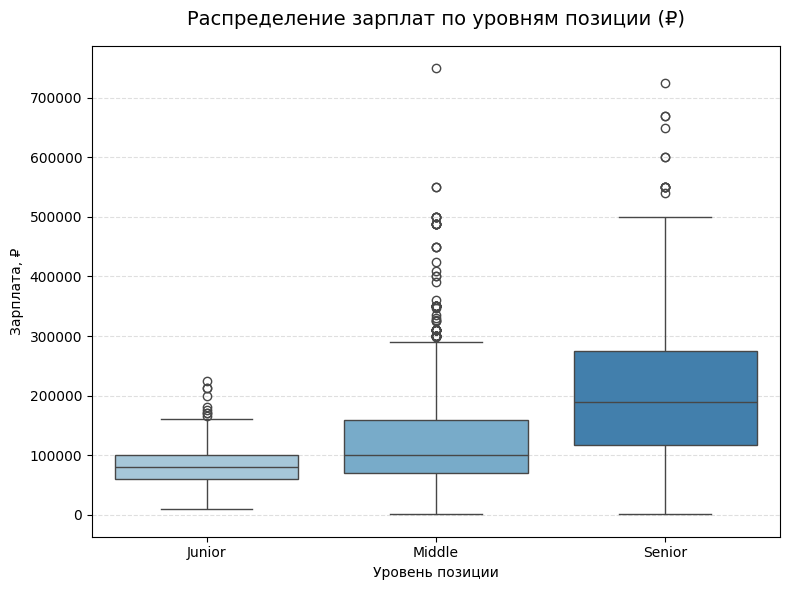

In [178]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df_rur[df_rur["level"] != "Не указано"],
    x="level",
    y="salary_value",
    order=["Junior", "Middle", "Senior"],
    palette=["#9ECAE1", "#6BAED6", "#3182BD"],
    showfliers=True
)

plt.title("Распределение зарплат по уровням позиции (₽)", fontsize=14, pad=15)
plt.xlabel("Уровень позиции")
plt.ylabel("Зарплата, ₽")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

Вывод:

Видем четкую иерархию самый высший уровень это синьер они зарабатывают больше всего

Потом идут мидл и джуниор разработчики

Хоть и есть выбросы у некоторых спецов (есть предположение что так как они в различных отрослях)

#Бизнес задача 10(Опыт работы на формат)

Проверить, как требуемый опыт влияет на формат работы
.

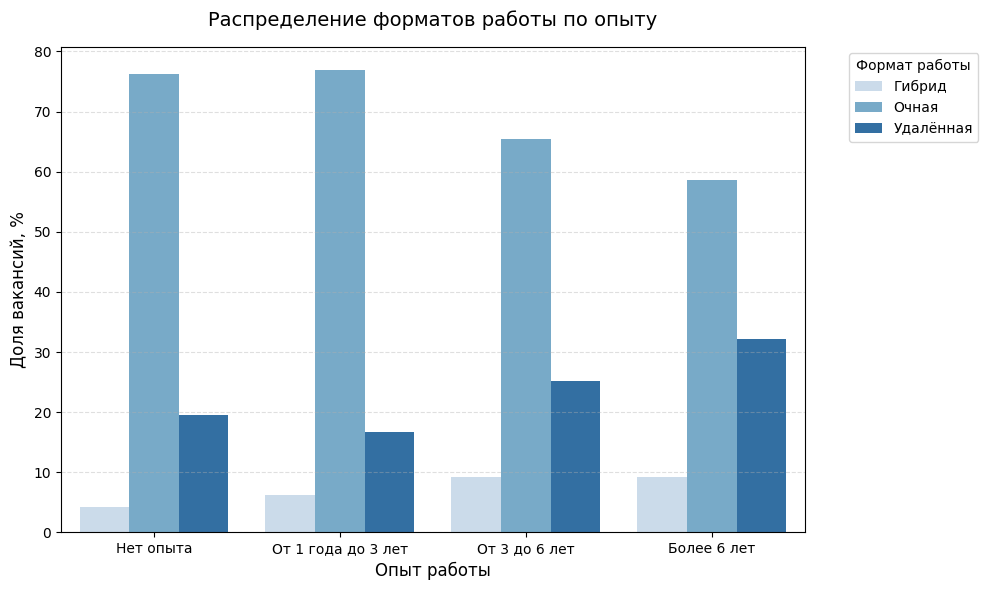

Доля форматов работы по опыту (%):
remote              Гибрид  Очная  Удалённая
experience_name                             
Нет опыта              4.2   76.2       19.6
От 1 года до 3 лет     6.3   77.0       16.7
От 3 до 6 лет          9.2   65.5       25.2
Более 6 лет            9.2   58.7       32.2


/tmp/ipython-input-2044980273.py:45: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



In [179]:
exp_remote = (
    data.groupby(["experience_name", "remote"])
    .size()
    .reset_index(name="count")
)

exp_remote["percent"] = (
    exp_remote.groupby("experience_name")["count"]
    .transform(lambda x: 100 * x / x.sum())
)

order_exp = [
    "Нет опыта",
    "От 1 года до 3 лет",
    "От 3 до 6 лет",
    "Более 6 лет"
]

exp_remote["experience_name"] = pd.Categorical(
    exp_remote["experience_name"],
    categories=order_exp,
    ordered=True
)
exp_remote = exp_remote.sort_values("experience_name")

plt.figure(figsize=(10, 6))
sns.barplot(
    data=exp_remote,
    x="experience_name",
    y="percent",
    hue="remote",
    palette="Blues"
)

plt.title("Распределение форматов работы по опыту", fontsize=14, pad=15)
plt.xlabel("Опыт работы", fontsize=12)
plt.ylabel("Доля вакансий, %", fontsize=12)
plt.legend(title="Формат работы", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

pivot_table = (
    exp_remote
    .pivot_table(index="experience_name", columns="remote", values="percent", fill_value=0)
    .round(1)
)

print("Доля форматов работы по опыту (%):")
print(pivot_table)



Вывод:

Видим четкую кареляцию что чем опытней человек тем больше ему доверяют работу удаленно

Так же видим что люди без опыта чаще всего будут работать в очном формате

#Бизнес задача 11(Отличие Москвы и Питера)

Понять, насколько зарплаты в Москве и Санкт-Петербурге отличаются от региональных.

In [180]:
def city_group(city):
    city = str(city).lower()
    if "москв" in city:
        return "Москва"
    elif "петер" in city or "спб" in city:
        return "Санкт-Петербург"
    else:
        return "Регионы"

df_rur["region_group"] = df_rur["city"].apply(city_group)

region_salary = (
    df_rur.groupby("region_group")["salary_value"]
    .agg(["mean", "median", "count"])
    .reset_index()
    .sort_values("mean", ascending=False)
)

print("Средняя и медианная зарплата по регионам:")
print(region_salary)


Средняя и медианная зарплата по регионам:
      region_group           mean    median  count
0           Москва  180468.696887  160000.0   5653
2  Санкт-Петербург  148083.952093  130000.0   1983
1          Регионы  109177.086985   90000.0  10065


/tmp/ipython-input-1495760645.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




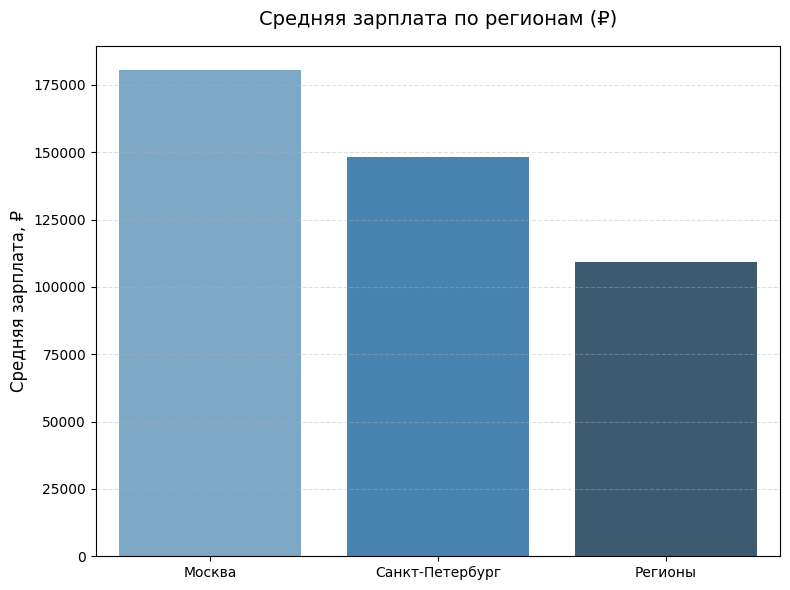

In [181]:
plt.figure(figsize=(8, 6))
sns.barplot(
    data=region_salary,
    x="region_group",
    y="mean",
    palette="Blues_d"
)
plt.title("Средняя зарплата по регионам (₽)", fontsize=14, pad=15)
plt.xlabel("")
plt.ylabel("Средняя зарплата, ₽", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

Вывод:Видим что они на среднию зарплату имеем разницу около 20-30 к рублей

Регионы же сильно отстают от первой и второй столицы России

#Бизнес задача 12(Топ работодателей по зарплатам)



Найти компании, которые платят выше рынка.

/tmp/ipython-input-945483605.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




ТОП-10 компаний с самыми высокими средними зарплатами (₽):
                                               employer     avg_salary  \
8874                                       эксперт плюс  400000.000000   
1163                                            selecty  311645.833333   
5167  министерство цифрового развития, связи и массо...  268737.864078   
4287                                клируэй текнолоджис  253750.000000   
329                                              dcloud  248181.818182   
7664                                             тензор  242887.323944   
8472                                                фто  236363.636364   
4794                                 линсофтверпродакшн  232606.837607   
2416                                            в кадре  227750.000000   
6400                                          профхолод  215892.857143   

      median_salary  count  above_market_%  
8874       400000.0     50           193.5  
1163       317500.0     24          

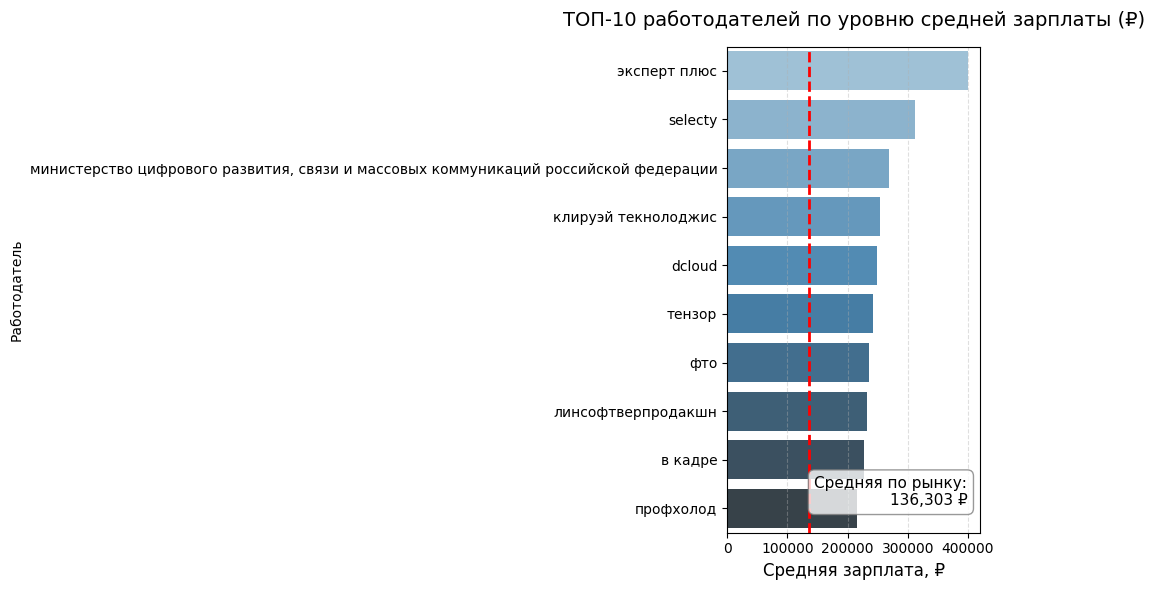


Средняя зарплата по рынку: 136,303 ₽

Превышение над средним по рынку (%):
                                               employer     avg_salary  \
8874                                       эксперт плюс  400000.000000   
1163                                            selecty  311645.833333   
5167  министерство цифрового развития, связи и массо...  268737.864078   
4287                                клируэй текнолоджис  253750.000000   
329                                              dcloud  248181.818182   
7664                                             тензор  242887.323944   
8472                                                фто  236363.636364   
4794                                 линсофтверпродакшн  232606.837607   
2416                                            в кадре  227750.000000   
6400                                          профхолод  215892.857143   

      above_market_%  
8874           193.5  
1163           128.6  
5167            97.2  
4287            8

In [182]:
employer_salary = (
    df_rur.groupby("employer")
    .agg(
        avg_salary=("salary_value", "mean"),
        median_salary=("salary_value", "median"),
        count=("salary_value", "size")
    )
    .reset_index()
)

employer_salary = employer_salary[employer_salary["count"] >= 20]


top_employers = employer_salary.sort_values("avg_salary", ascending=False).head(10)

market_avg = df_rur["salary_value"].mean()

top_employers["above_market_%"] = (
    (top_employers["avg_salary"] / market_avg - 1) * 100
).round(1)

print("ТОП-10 компаний с самыми высокими средними зарплатами (₽):")
print(top_employers[["employer", "avg_salary", "median_salary", "count", "above_market_%"]])

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_employers,
    x="avg_salary",
    y="employer",
    palette="Blues_d"
)

plt.axvline(x=market_avg, color="red", linestyle="--", linewidth=2)

plt.title("ТОП-10 работодателей по уровню средней зарплаты (₽)", fontsize=14, pad=15)
plt.xlabel("Средняя зарплата, ₽", fontsize=12)
plt.ylabel("Работодатель")
plt.grid(axis="x", linestyle="--", alpha=0.4)

plt.text(
    0.95, 0.05,
    f"Средняя по рынку:\n{market_avg:,.0f} ₽",
    ha="right", va="bottom", transform=plt.gca().transAxes,
    fontsize=11, color="black",
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8, edgecolor="gray")
)

plt.tight_layout()
plt.show()

print(f"\nСредняя зарплата по рынку: {market_avg:,.0f} ₽")
print("\nПревышение над средним по рынку (%):")
print(top_employers[["employer", "avg_salary", "above_market_%"]])


Вывод:

Некоторые компании платят намного больше рынка за IT спецов

#Бизнес задачи 13(Распределение)

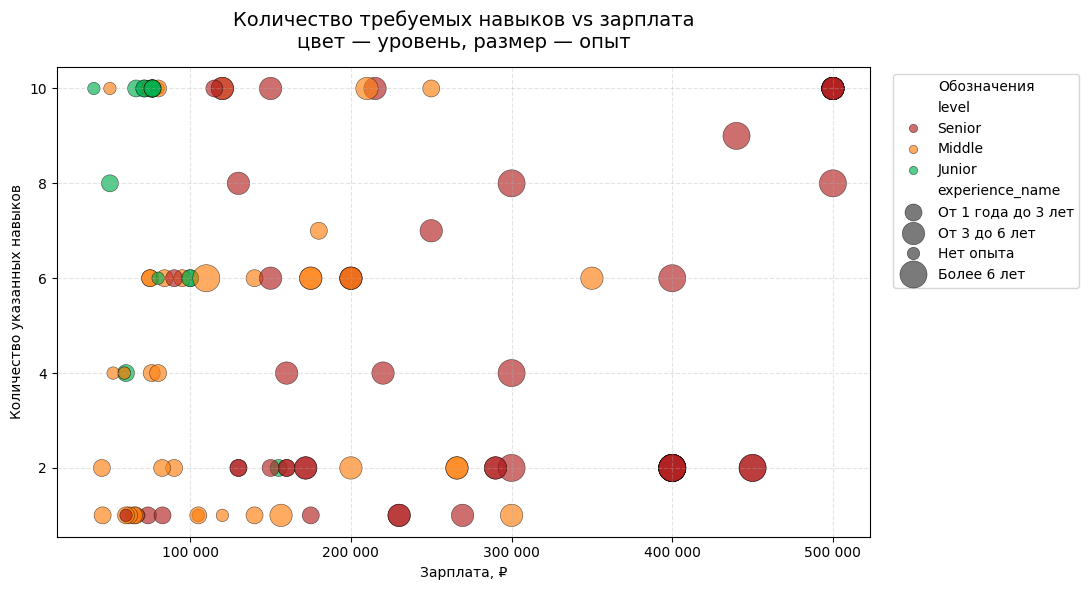

In [183]:
data['salary_value'] = data.apply(calc_salary, axis=1)
data = data[(data['salary_value'] >= 10_000) & (data['salary_value'] <= 1_000_000)].copy()

data['level'] = data['title'].apply(detect_level)
data = data[data['level'].isin(['Junior','Middle','Senior'])].copy()

data['skills_count'] = data['skills'].apply(
    lambda x: len(str(x).split(',')) if pd.notna(x) and str(x).strip() else 0
)
data = data[data['skills_count'] > 0].copy()

exp_order = ['Нет опыта', 'От 1 года до 3 лет', 'От 3 до 6 лет', 'Более 6 лет']
data['experience_name'] = data.get('experience_name').astype(str)
data = data[data['experience_name'].isin(exp_order)].copy()

exp_sizes = {
    'Нет опыта': 80,
    'От 1 года до 3 лет': 150,
    'От 3 до 6 лет': 260,
    'Более 6 лет': 380
}

palette = {'Junior': '#00B050', 'Middle': '#FF7F0E', 'Senior': '#B22222'}

plt.figure(figsize=(11,6))
ax = sns.scatterplot(
    data=data,
    x='salary_value',
    y='skills_count',
    hue='level',
    size='experience_name',    # размер = категория опыта
    sizes=exp_sizes,           # фиксируем размеры для понятной легенды
    alpha=0.65,
    palette=palette,
    edgecolor='black',
    linewidth=0.4
)

ax.set_title('Количество требуемых навыков vs зарплата\nцвет — уровень, размер — опыт', pad=14, fontsize=14)
ax.set_xlabel('Зарплата, ₽')
ax.set_ylabel('Количество указанных навыков')
ax.grid(True, which='both', linestyle='--', alpha=0.35)
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

handles, labels = ax.get_legend_handles_labels()
ax.legend(title='Обозначения', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()




Вывод:

Заивисимость на лицо что мидл и синьор разработчики остаются самыми желанными на рынка(даже учитывая большую зп) из за навыково которыми они владеют

#Общие выводы

1. Общая ситуация на рынке IT-вакансий

IT остаётся высокодоходной отраслью. Средняя зарплата по IT-вакансиям существенно выше среднего по рынку: медиана ~120–150 тыс ₽, верхние 10 % — от 250–300 тыс ₽ и выше.

Рынок сбалансирован по опыту: востребованы как начинающие (Junior, стажёры), так и опытные специалисты (Middle, Senior).

IT-вакансии представлены по всей стране, но концентрируются в крупных центрах: Москва, Санкт-Петербург, Екатеринбург, Новосибирск, Казань, Краснодар.

2. Зарплатная ситуация и привлекательные сегменты

ТОП-10 профессий по уровню дохода: разработчики (особенно backend, full-stack, mobile), DevOps, data-инженеры и аналитики данных.

ТОП-10 городов по зарплатам: Москва и Санкт-Петербург остаются лидерами, но в некоторых регионах (Казань, Екатеринбург, Новосибирск) зарплаты приближаются к столичным при более низких издержках.

Средние зарплаты по грейдам:

Junior — 60–100 тыс ₽

Middle — 120–180 тыс ₽

Senior — 200–350 тыс ₽

Разрыв между Middle и Senior достигает 2×, что говорит о высокой ценности экспертизы.

Вывод: оптимально заходить в сегменты Middle-специалистов и опытных Junior-ов, где спрос стабилен, а дефицит кадров сохраняется.

3. Спрос по направлениям и навыкам

ТОП-навыки: Python, SQL, Linux, Git, Docker, JavaScript, REST API, React, Kubernetes, Django, Pandas.

Отрасли с наибольшей оплатой: Data-аналитика, DevOps, Разработка ПО, Финансы-IT.

Часто встречающиеся требования: «опыт работы с данными», «знание английского», «работа в команде», «гибкие методологии (Agile/Scrum)».

Вывод: наиболее перспективные направления для входа — разработка и аналитика данных, а также инфраструктурные IT-услуги (DevOps, автоматизация).

4. География и форматы работы

Москва и Санкт-Петербург дают больше всего вакансий, но удалённая работа активно растёт — её доля превышает 30 % от всех IT-вакансий.

Гибридный формат распространён среди крупных компаний, особенно в аналитике и разработке.

Фултайм преобладает (около 80 %), но растёт доля частичной занятости и проектных контрактов.

Вывод: если компания выходит на рынок, целесообразно сразу предлагать удалённые и гибридные форматы, чтобы привлекать специалистов по всей стране и экономить на офисных расходах.

5. Рынок для студентов и начинающих

Вакансий без опыта или для стажёров около 10–12 % от общего объёма.

Самые частые должности — Junior-разработчик, аналитик, тестировщик, support-инженер.

Зарплаты у студентов в 2–3 раза ниже средних по рынку (40–70 тыс ₽), но это основной кадровый резерв.

Вывод: стоит развивать систему стажировок и обучения, чтобы формировать собственный поток молодых кадров и снижать затраты на найм Senior-ов

6. Конкуренция и работодатели-лидеры

ТОП-20 компаний по количеству вакансий — крупные технологические и финансовые игроки (Яндекс, VK, Сбер, Тинькофф, Ozon, Лаборатория Касперского и др.).

Компании, которые «платят выше рынка», как правило, специализируются на финтехе, e-commerce и data-инфраструктуре.

Разрыв в зарплатах между лидерами и средней по рынку — до 40 %, что показывает готовность кандидатов уходить туда, где компенсация выше.

Вывод: чтобы конкурировать, новому игроку нужно предложить:

прозрачную систему грейдов и роста;

бонусы (гибкий график, обучение, соцпакет);

скоростной процесс найма (в IT-рынке скорость критична).

7. Тренды и прогноз

Динамика публикации вакансий показывает рост в направлениях data, backend, machine learning и product management.

По временным рядам (rolling mean) видно, что спрос на эти профессии стабильно растёт последние месяцы, что коррелирует с цифровизацией бизнеса и импортозамещением.

Вывод: перспективные ниши для ближайшего года:

Data Science и аналитика;

Cloud/DevOps-решения;

Backend (Python, Go, Java);

Cybersecurity.